#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm

In [2]:
from numpy.linalg import eig, svd
from sklearn.decomposition import PCA

In [3]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

In [4]:
from data_loader import makeTensorLoaders

#### Test for CUDA

In [5]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
    device = torch.device('cpu')
else:
    print('GPU found, training on GPU')
    device = torch.device('cuda')

GPU found, training on GPU


#### Simulation parameters

In [6]:
N = 128 ## number of recurrent neurons
nsecs = 50 ## time
n_channels = 1

In [7]:
nRuns = 5

#### Train and test datasets

In [8]:
def random_assignment(numSamps, n, p):
    # Create a zero array of shape (numSamps, n)
    arr = np.random.choice([-1, 1], size=(numSamps, n))
    
    # Randomly assign 1 or -1 to elements with probability p
    rand_arr = np.random.random(arr.shape)
    arr[np.random.random(arr.shape) > p] = 0
    
    return arr

In [9]:
nTrain = 6000
nTest = 1000
prob_delta = 0.05

In [10]:
batch_size = 200

In [11]:
def flipflop_output(input_array):
    output_array = np.zeros_like(input_array)
    current_state = 0  # Track the current state
    
    for tt in range(len(input_array)):
        if input_array[tt] !=0:
            current_state = input_array[tt]
            output_array[tt:] = current_state
            
    return output_array

In [12]:
data_in_train = {}
data_in_test = {}

In [13]:
data_out_train = {}
data_out_test = {}

In [14]:
for cntr in range(nRuns):
    data_in_train[cntr] = random_assignment(nTrain, nsecs, prob_delta)
    data_in_test[cntr] = random_assignment(nTest, nsecs, prob_delta)
    
    data_out_train[cntr] = np.zeros_like(data_in_train[cntr])
    data_out_test[cntr] = np.zeros_like(data_in_test[cntr])
    
    for ii in range(nTrain):
        data_out_train[cntr][ii] = flipflop_output(data_in_train[cntr][ii])
        
    for ii in range(nTest):
        data_out_test[cntr][ii] = flipflop_output(data_in_test[cntr][ii])

In [15]:
train_loader = {}
test_loader = {}

In [16]:
for cntr in range(nRuns):
    train_loader[cntr] = makeTensorLoaders((data_in_train[cntr], data_out_train[cntr]), batch_size, shuffle=True)
    test_loader[cntr] = makeTensorLoaders((data_in_test[cntr], data_out_test[cntr]), batch_size, shuffle=False)

#### Model and other hyper-params

In [17]:
num_layers = 1
input_size = n_channels
hidden_size = N
output_size = input_size

In [18]:
def initialize_weights(N, index_ranges, signs):
    weights = np.zeros((N, N))
    for ii, (start, end) in enumerate(index_ranges):
        limit = 1 / np.sqrt(N) if signs[ii] == 1 else -1/np.sqrt(N)
        weights[:, start:end] = np.random.uniform(0, limit, size=(N, end-start))
    return weights

In [19]:
def generate_mask(weights, index_ranges, signs):
    mask = np.zeros_like(weights)
    for i, (start, end) in enumerate(index_ranges):
        if signs[i] == 1:
            mask[:, start:end] = np.where(weights[:, start:end] > 0, 1, 0)
        elif signs[i] == -1:
            mask[:, start:end] = np.where(weights[:, start:end] < 0, 1, 0)
    return mask

In [20]:
# Define the neural network
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, device):
        
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, output_size)
        self.output_size = output_size
        self.device = device

    def forward(self, x):
        m = nn.Tanh()
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        nSamp, nSteps, inDim = x.shape
        
        ops = torch.zeros(nSamp,nSteps,self.hidden_size, requires_grad=False).to(self.device)
        pred = torch.zeros(nSamp,nSteps,self.output_size, requires_grad=False).to(self.device)
        
        for ii in range(nSteps):
            ip = torch.unsqueeze(x[:,ii,:],1)
            op, ht = self.rnn(ip,h0) ## pass 1 timestep through RNN
            fr_mask = ht.clone()>0
            htt = fr_mask*ht.clone() ## mask firing rate
            h0 = htt ## update hidden state
            ops[:,ii,:] = torch.squeeze(op.clone())

            ## Final prediction at every timestep
            pred[:,ii,:] = m(self.fc(ops[:, ii, :].clone()))
        
        return pred, htt

In [21]:
frac_ex = 0.8
frac_in = 1-frac_ex

In [22]:
signs = [1,-1]
index_ranges = [(0,int(N*frac_ex)),(int(N*frac_ex),N)]

In [23]:
# Initialize the model
model = {}
weights_init = {}

In [24]:
for cntr in range(nRuns):
    model[cntr] = SimpleRNN(input_size, hidden_size, output_size, device).to(device)
    weights_init[cntr] = initialize_weights(N,index_ranges,signs)
    model[cntr].rnn.weight_hh_l0.data = torch.from_numpy(weights_init[cntr]).float().to(device)

Text(0.5, 1.0, 'Initial Weights: Dales Backprop')

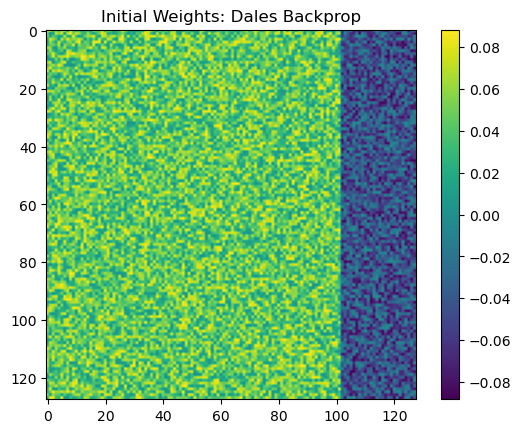

In [25]:
kk = 0

plt.imshow(weights_init[kk])
plt.colorbar()
plt.title('Initial Weights: Dales Backprop')

Text(0, 0.5, 'Counts')

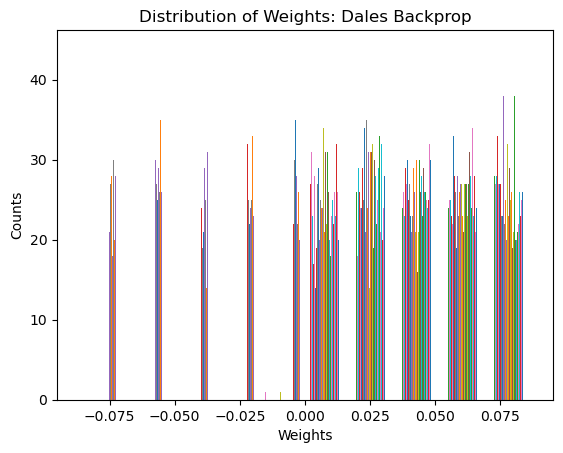

In [26]:
plt.hist(weights_init[kk])
plt.title('Distribution of Weights: Dales Backprop')
plt.xlabel('Weights')
plt.ylabel('Counts')

#### Model training

In [27]:
num_epochs = 100
learning_rate = 0.001

In [28]:
criterion = nn.MSELoss()

optimizer = {}
for cntr in range(nRuns):
    optimizer[cntr] = optim.Adam(model[cntr].parameters(), lr=learning_rate)

In [29]:
train_losses = np.zeros((nRuns, num_epochs))
test_losses = np.zeros((nRuns, num_epochs))

In [30]:
for run in tqdm(range(nRuns)):
    model[run].train()
    train_loss_min = np.Inf
    
    for epoch in range(1, num_epochs+1):
        print('Epoch: ',epoch)

        train_loss = 0.0
        test_loss = 0.0
        
        for inputs, targets in train_loader[run]:
            if train_on_gpu:
                inputs, targets = torch.unsqueeze(inputs.float().cuda(),-1), torch.unsqueeze(targets.float().cuda(),-1)
                model[run].cuda()
            else:
                inputs, targets = torch.unsqueeze(inputs.float(),-1), torch.unsqueeze(targets.float(),-1)

            optimizer[run].zero_grad()
            outputs, firing_rates = model[run](inputs)
            if train_on_gpu:
                outputs = outputs.cuda()
            loss = criterion(outputs, targets)
            train_loss += loss.item()

            loss.backward()
            optimizer[run].step()

            ## Dale's backprop
            w = model[run].rnn.weight_hh_l0.detach().cpu().numpy()
            mask = generate_mask(w, index_ranges, signs)
            wm = w*mask
            model[run].rnn.weight_hh_l0.data = torch.from_numpy(wm).float().to(device)

        if train_loss< train_loss_min:
            print('Epoch: {}, Train Loss Decreased!! ({:.6f}-->{:.6f})'.format(epoch,train_loss_min,train_loss))
            train_loss_min = train_loss
        
        train_losses[run][epoch-1] = train_loss

        for inputs_test, targets_test in test_loader[run]:
            if train_on_gpu:
                inputs_test, targets_test = torch.unsqueeze(inputs_test.float().cuda(),-1), torch.unsqueeze(targets_test.float().cuda(),-1)
                model[run].cuda()
            else:
                inputs_test, targets_test = torch.unsqueeze(inputs_test.float(),-1), torch.unsqueeze(targets_test.float(),-1)

            outputs_test, firing_rates_test = model[run](inputs_test)
            if train_on_gpu:
                outputs_test = outputs_test.cuda()
            loss_test = criterion(outputs_test, targets_test)
            test_loss += loss_test.item()
            
        test_losses[run][epoch-1] = test_loss

        print('Epoch: {}, Test Loss({:.6f})'.format(epoch,test_loss))

Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->21.775998)
Epoch: 1, Test Loss(3.233647)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (21.775998-->19.406025)
Epoch: 2, Test Loss(3.201532)
Epoch:  3
Epoch: 3, Train Loss Decreased!! (19.406025-->18.994705)
Epoch: 3, Test Loss(3.011869)
Epoch:  4
Epoch: 4, Train Loss Decreased!! (18.994705-->15.612233)
Epoch: 4, Test Loss(2.244458)
Epoch:  5
Epoch: 5, Train Loss Decreased!! (15.612233-->13.647663)
Epoch: 5, Test Loss(2.267163)
Epoch:  6
Epoch: 6, Train Loss Decreased!! (13.647663-->13.177730)
Epoch: 6, Test Loss(2.907860)
Epoch:  7
Epoch: 7, Train Loss Decreased!! (13.177730-->13.161945)
Epoch: 7, Test Loss(2.170420)
Epoch:  8
Epoch: 8, Test Loss(2.146976)
Epoch:  9
Epoch: 9, Train Loss Decreased!! (13.161945-->12.624364)
Epoch: 9, Test Loss(2.090677)
Epoch:  10
Epoch: 10, Train Loss Decreased!! (12.624364-->12.093889)
Epoch: 10, Test Loss(1.775057)
Epoch:  11
Epoch: 11, Test Loss(2.537920)
Epoch:  12
Epoch: 12, Test Loss(2.076555)
Epoch:

Epoch: 93, Test Loss(0.001735)
Epoch:  94
Epoch: 94, Train Loss Decreased!! (0.011405-->0.011035)
Epoch: 94, Test Loss(0.001682)
Epoch:  95
Epoch: 95, Train Loss Decreased!! (0.011035-->0.010692)
Epoch: 95, Test Loss(0.001634)
Epoch:  96
Epoch: 96, Train Loss Decreased!! (0.010692-->0.010384)
Epoch: 96, Test Loss(0.001585)
Epoch:  97
Epoch: 97, Train Loss Decreased!! (0.010384-->0.010061)
Epoch: 97, Test Loss(0.001535)
Epoch:  98
Epoch: 98, Train Loss Decreased!! (0.010061-->0.009757)
Epoch: 98, Test Loss(0.001488)
Epoch:  99
Epoch: 99, Test Loss(0.001471)
Epoch:  100
Epoch: 100, Train Loss Decreased!! (0.009757-->0.009387)
Epoch: 100, Test Loss(0.001417)
Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->21.456013)
Epoch: 1, Test Loss(3.175545)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (21.456013-->19.509236)
Epoch: 2, Test Loss(3.172454)
Epoch:  3
Epoch: 3, Train Loss Decreased!! (19.509236-->17.644633)
Epoch: 3, Test Loss(2.487854)
Epoch:  4
Epoch: 4, Train Loss Decreased!! (17.6446

Epoch: 84, Test Loss(0.002902)
Epoch:  85
Epoch: 85, Train Loss Decreased!! (0.016405-->0.015803)
Epoch: 85, Test Loss(0.002800)
Epoch:  86
Epoch: 86, Train Loss Decreased!! (0.015803-->0.015234)
Epoch: 86, Test Loss(0.002697)
Epoch:  87
Epoch: 87, Train Loss Decreased!! (0.015234-->0.014687)
Epoch: 87, Test Loss(0.002600)
Epoch:  88
Epoch: 88, Train Loss Decreased!! (0.014687-->0.014176)
Epoch: 88, Test Loss(0.002500)
Epoch:  89
Epoch: 89, Train Loss Decreased!! (0.014176-->0.013678)
Epoch: 89, Test Loss(0.002421)
Epoch:  90
Epoch: 90, Train Loss Decreased!! (0.013678-->0.013187)
Epoch: 90, Test Loss(0.002326)
Epoch:  91
Epoch: 91, Train Loss Decreased!! (0.013187-->0.012732)
Epoch: 91, Test Loss(0.002242)
Epoch:  92
Epoch: 92, Train Loss Decreased!! (0.012732-->0.012299)
Epoch: 92, Test Loss(0.002165)
Epoch:  93
Epoch: 93, Train Loss Decreased!! (0.012299-->0.011881)
Epoch: 93, Test Loss(0.002092)
Epoch:  94
Epoch: 94, Train Loss Decreased!! (0.011881-->0.011490)
Epoch: 94, Test Loss

Epoch: 82, Test Loss(0.008443)
Epoch:  83
Epoch: 83, Train Loss Decreased!! (0.048690-->0.047149)
Epoch: 83, Test Loss(0.008194)
Epoch:  84
Epoch: 84, Train Loss Decreased!! (0.047149-->0.045688)
Epoch: 84, Test Loss(0.007956)
Epoch:  85
Epoch: 85, Train Loss Decreased!! (0.045688-->0.044333)
Epoch: 85, Test Loss(0.007725)
Epoch:  86
Epoch: 86, Train Loss Decreased!! (0.044333-->0.042940)
Epoch: 86, Test Loss(0.007504)
Epoch:  87
Epoch: 87, Train Loss Decreased!! (0.042940-->0.041661)
Epoch: 87, Test Loss(0.007290)
Epoch:  88
Epoch: 88, Train Loss Decreased!! (0.041661-->0.040416)
Epoch: 88, Test Loss(0.007083)
Epoch:  89
Epoch: 89, Train Loss Decreased!! (0.040416-->0.039215)
Epoch: 89, Test Loss(0.006885)
Epoch:  90
Epoch: 90, Train Loss Decreased!! (0.039215-->0.038059)
Epoch: 90, Test Loss(0.006689)
Epoch:  91
Epoch: 91, Train Loss Decreased!! (0.038059-->0.036938)
Epoch: 91, Test Loss(0.006500)
Epoch:  92
Epoch: 92, Train Loss Decreased!! (0.036938-->0.035878)
Epoch: 92, Test Loss

Epoch: 67, Train Loss Decreased!! (0.005765-->0.005591)
Epoch: 67, Test Loss(0.000965)
Epoch:  68
Epoch: 68, Train Loss Decreased!! (0.005591-->0.005460)
Epoch: 68, Test Loss(0.002323)
Epoch:  69
Epoch: 69, Test Loss(0.567111)
Epoch:  70
Epoch: 70, Test Loss(0.041283)
Epoch:  71
Epoch: 71, Test Loss(0.012933)
Epoch:  72
Epoch: 72, Test Loss(0.008489)
Epoch:  73
Epoch: 73, Test Loss(0.006194)
Epoch:  74
Epoch: 74, Test Loss(0.003731)
Epoch:  75
Epoch: 75, Test Loss(0.002843)
Epoch:  76
Epoch: 76, Test Loss(0.002396)
Epoch:  77
Epoch: 77, Test Loss(0.002479)
Epoch:  78
Epoch: 78, Test Loss(0.002641)
Epoch:  79
Epoch: 79, Test Loss(0.002110)
Epoch:  80
Epoch: 80, Test Loss(0.002307)
Epoch:  81
Epoch: 81, Test Loss(0.001859)
Epoch:  82
Epoch: 82, Test Loss(0.001747)
Epoch:  83
Epoch: 83, Test Loss(0.001494)
Epoch:  84
Epoch: 84, Test Loss(0.001410)
Epoch:  85
Epoch: 85, Test Loss(0.001350)
Epoch:  86
Epoch: 86, Test Loss(0.001294)
Epoch:  87
Epoch: 87, Test Loss(0.001244)
Epoch:  88
Epoch:

Epoch: 75, Test Loss(0.008228)
Epoch:  76
Epoch: 76, Train Loss Decreased!! (0.053637-->0.051618)
Epoch: 76, Test Loss(0.007917)
Epoch:  77
Epoch: 77, Train Loss Decreased!! (0.051618-->0.049686)
Epoch: 77, Test Loss(0.007611)
Epoch:  78
Epoch: 78, Train Loss Decreased!! (0.049686-->0.047845)
Epoch: 78, Test Loss(0.007300)
Epoch:  79
Epoch: 79, Train Loss Decreased!! (0.047845-->0.045955)
Epoch: 79, Test Loss(0.007008)
Epoch:  80
Epoch: 80, Train Loss Decreased!! (0.045955-->0.044182)
Epoch: 80, Test Loss(0.006737)
Epoch:  81
Epoch: 81, Train Loss Decreased!! (0.044182-->0.042479)
Epoch: 81, Test Loss(0.006460)
Epoch:  82
Epoch: 82, Train Loss Decreased!! (0.042479-->0.040851)
Epoch: 82, Test Loss(0.006206)
Epoch:  83
Epoch: 83, Train Loss Decreased!! (0.040851-->0.039204)
Epoch: 83, Test Loss(0.005958)
Epoch:  84
Epoch: 84, Train Loss Decreased!! (0.039204-->0.037751)
Epoch: 84, Test Loss(0.005709)
Epoch:  85
Epoch: 85, Train Loss Decreased!! (0.037751-->0.036302)
Epoch: 85, Test Loss

In [31]:
outputs_np = outputs.detach().cpu().numpy()
targets_np = targets.detach().cpu().numpy()
firing_rates_np = firing_rates.detach().cpu().numpy()

In [32]:
outputs_test_np = outputs_test.detach().cpu().numpy()
targets_test_np = targets_test.detach().cpu().numpy()
firing_rates_test_np = firing_rates_test.detach().cpu().numpy()

Text(0.5, 1.0, 'Test')

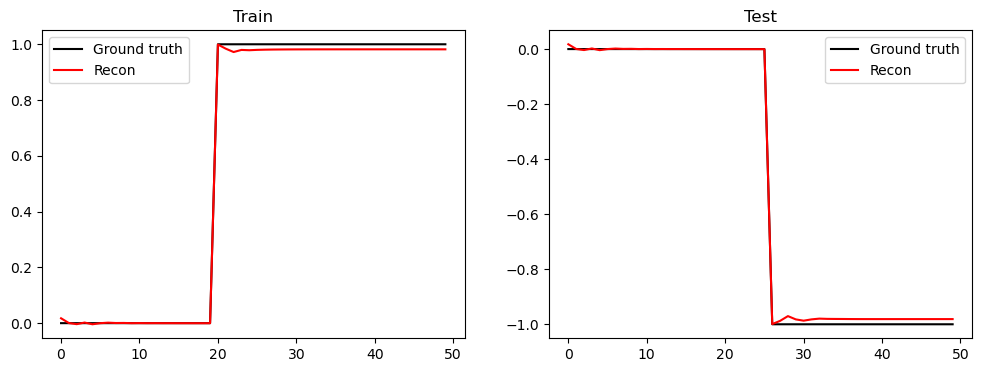

In [33]:
kk = 10 ## all zeros freaks it out

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(targets_np[kk],label='Ground truth',color='k')
plt.plot(outputs_np[kk],label='Recon',color='r')
plt.legend()
plt.title('Train')

plt.subplot(122)
plt.plot(targets_test_np[kk],label='Ground truth',color='k')
plt.plot(outputs_test_np[kk],label='Recon',color='r')
plt.legend()
plt.title('Test')

In [34]:
weights_final = {}
for cntr in range(nRuns):
    weights_final[cntr] = model[cntr].rnn.weight_hh_l0.detach().cpu().numpy()

Text(0.5, 1.0, 'Final Weights')

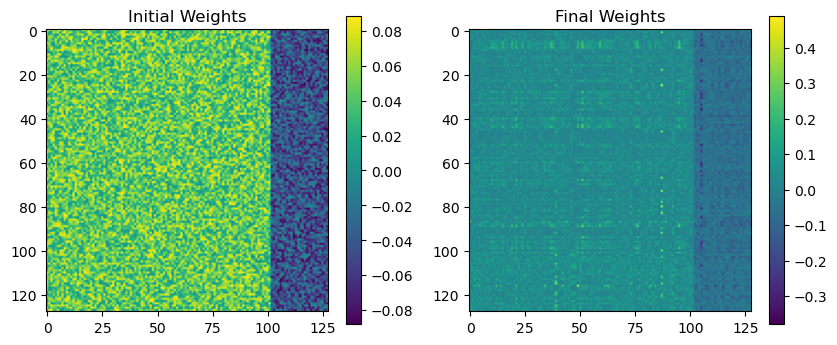

In [35]:
kk = 0

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(weights_init[kk])
plt.colorbar()
plt.title('Initial Weights')

plt.subplot(122)
plt.imshow(weights_final[kk])
plt.colorbar()
plt.title('Final Weights')

Text(0, 0.5, 'Counts')

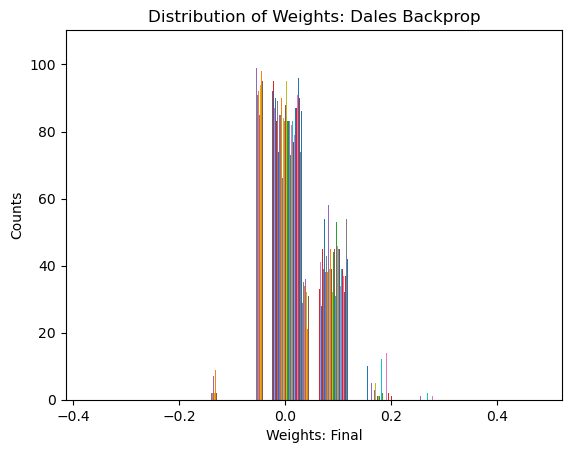

In [36]:
plt.hist(weights_final[kk])
plt.title('Distribution of Weights: Dales Backprop')
plt.xlabel('Weights: Final')
plt.ylabel('Counts')

In [44]:
mean_train_losses = np.mean(train_losses, axis=0)
variance_train_losses = np.var(train_losses, axis=0)

mean_test_losses = np.mean(test_losses, axis=0)
variance_test_losses = np.var(test_losses, axis=0)

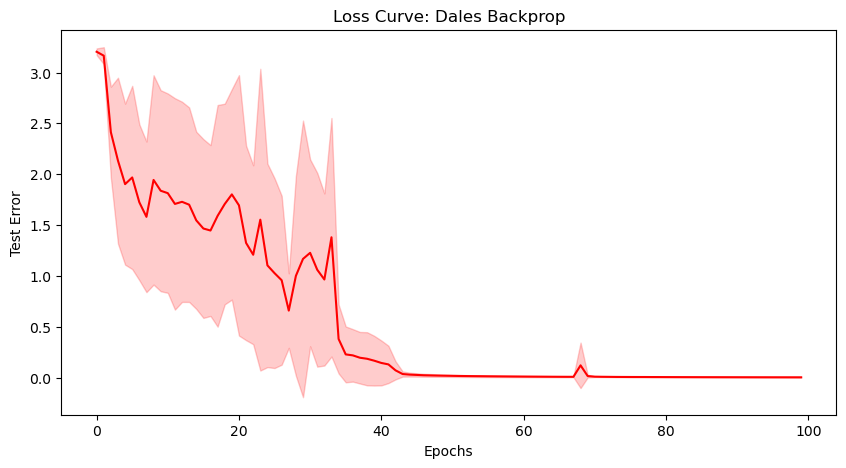

In [45]:
# Define x-axis (epochs)
x = np.arange(num_epochs)

# Plot shaded error bar using Seaborn
plt.figure(figsize=(10, 5))
# sns.lineplot(x=x, y=mean_train_losses, color='r')
# plt.fill_between(x, mean_train_losses - np.sqrt(variance_train_losses), mean_train_losses + np.sqrt(variance_train_losses),
#                  color='r', alpha=0.2)

sns.lineplot(x=x, y=mean_test_losses, color='r')
plt.fill_between(x, mean_test_losses - np.sqrt(variance_test_losses), mean_test_losses + np.sqrt(variance_test_losses),
                 color='r', alpha=0.2)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Test Error')
plt.title('Loss Curve: Dales Backprop')

# Show plot
plt.show()

#### Saves

In [46]:
## Save train, test losses + accuracies
np.save('flipflop_train_losses_dales_backprop',train_losses)
np.save('flipflop_test_losses_dales_backprop',test_losses)

In [47]:
# Save dictionary to a Numpy .npz file
np.savez('flipflop_weights_init_dales.npz', weights_init, pickle=True)
np.savez('flipflop_weights_final_dales.npz', weights_final, pickle=True)